In [39]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
from typing import List

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

from llama_index.core import SimpleDirectoryReader
from llama_index.core.llms import ChatMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter

from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

In [4]:
load_dotenv(".env")
login(os.getenv("hf_token"))
openai_token = os.getenv("openai_api_key")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/s448780/.cache/huggingface/token
Login successful


## loading data

In [5]:
docs = SimpleDirectoryReader("./text/").load_data()

In [33]:
# docs[0].text

## data chunking

In [14]:
MARKDOWN_SEPARATORS = ["\n\n", "\n"]

In [15]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    # no chunk overlap
    separators = MARKDOWN_SEPARATORS,
    is_separator_regex = False
)

In [27]:
chunks = text_splitter.split_text(docs[0].text)

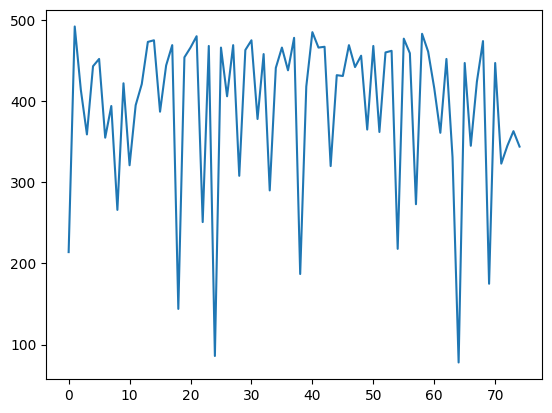

In [31]:
chunk_sizes = []
for chunk in chunks:
    chunk_sizes.append(len(chunk))

plt.plot(chunk_sizes)

In [32]:
chunks[0]

"DISQUALIFIED\n\nBY CHARLES L. FONTENAY\n\n\nAfter the morning inspection tour, Tardo, the Solar Council's Planetary\nAid agent, and his companion, Peo, were taken to the castle which stood\non a hill overlooking the area."

## openai llm

In [51]:
llm = OpenAI(temperature=0, n=1, model="gpt-3.5-turbo", api_key=openai_token)
embed_model = OpenAIEmbedding()

## cot answer

In [64]:
def generate_cot_answer(llm:OpenAI, question:str, context:str) -> List[str]:
    prompt = f"""
        Question: {question}\nContext: {context}\n
        Answer this question using the information given in the context above. Here is things to pay attention to:
        - First provide step-by-step reasoning on how to answer the question.
        - In the reasoning, if you need to copy paste some sentences from the context, include them in ##begin_quote## and ##end_quote##. This would mean that things outside of ##begin_quote## and ##end_quote## are not directly copy paste from the context.
        - End your response with final answer in the form <ANSWER>: $answer, the answer should be succinct.
    """
    messages = [
        ChatMessage(
            role="system",
            content="You are a helpful assistant who can provide an answer given a question and relevant context.",
        ),
        ChatMessage(role="user", content=prompt),
    ]
    return str(llm.chat(messages)).split("\n")

## q/a pair

In [58]:
def generate_qa_pair(llm:OpenAI, chunk:str, num_questions:int = 2) -> List[str]:
    messages = [
        ChatMessage(
            role="system",
            content='''
            You are a synthetic question-answer pair generator. 
            Given a chunk of context about some topic(s), generate %s example questions a user could ask and would be answered using information from the chunk.
            Add chain-of-thought
            For example, if the given context was a Wikipedia paragraph about the United States, an example question could be 'How many states are in the United States?' and answer would be 50. 
            The questions should be able to be answered in a few words or less.'''
            % (num_questions),
        ),
        ChatMessage(role = "user", content = chunk),
    ]
    # for message in messages:
    #     print(message)

    queries = str(llm.chat(messages)).split("\n")
    print(queries)
    # questions = [self.strip_str(q) for q in queries]
    # questions = [q for q in questions if any(c.isalpha() for c in q)][:x]

    # num_questions_generated = len(questions)
    # if num_questions_generated < x:
    #     warnings.warn(
    #         f"Fewer questions generated ({num_questions_generated}) "
    #         f"than requested ({x})."
    #     )

    # return questions

In [59]:
generate_qa_pair(llm, chunks[0])

['assistant: 1. Who is Tardo in "Disqualified" by Charles L. Fontenay?', "- Tardo is the Solar Council's Planetary Aid agent.", '', '2. Where is the castle located in "Disqualified" by Charles L. Fontenay?', '- The castle is located on a hill overlooking the area.']


In [63]:
chunks[0]

"DISQUALIFIED\n\nBY CHARLES L. FONTENAY\n\n\nAfter the morning inspection tour, Tardo, the Solar Council's Planetary\nAid agent, and his companion, Peo, were taken to the castle which stood\non a hill overlooking the area."

In [68]:
generate_cot_answer(llm, '''Who is Tardo in "Disqualified" by Charles L. Fontenay?''', chunks[0].replace("\n", " "))

['assistant: To determine who Tardo is in "Disqualified" by Charles L. Fontenay based on the provided context, we can follow these steps:',
 '',
 '1. Identify the characters mentioned in the context: Tardo and Peo.',
 '2. Note that Tardo is described as "the Solar Council\'s Planetary Aid agent."',
 '3. The context mentions that Tardo and Peo were taken to the castle, indicating that Tardo is involved in some official capacity related to aid and possibly governance.',
 '',
 'Therefore, based on the context provided, we can conclude that Tardo is the Solar Council\'s Planetary Aid agent in "Disqualified" by Charles L. Fontenay.',
 '',
 "<ANSWER>: Tardo is the Solar Council's Planetary Aid agent."]

In [67]:
print("DISQUALIFIED\n\nBY CHARLES L. FONTENAY\n\n\nAfter the morning inspection tour, Tardo, the Solar Council's Planetary\nAid agent, and his companion, Peo, were taken to the castle which stood\non a hill overlooking the area.")

DISQUALIFIED

BY CHARLES L. FONTENAY


After the morning inspection tour, Tardo, the Solar Council's Planetary
Aid agent, and his companion, Peo, were taken to the castle which stood
on a hill overlooking the area.
